# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [184]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [185]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

## 1. Complete pooling
The 8 groups are from the same distribution then the mean of the improvement should be the same for each group. Here I just set the prior distribution as one normal distribution with fixed mu and tau for all 8 groups.

 [-----------------100%-----------------] 100000 of 100000 complete in 4.8 secPlotting cp_mean


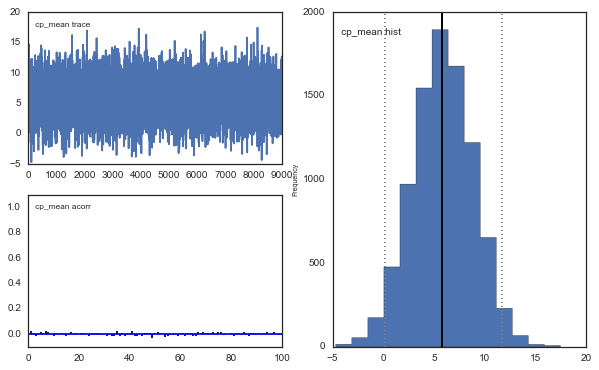

In [187]:
mu = 2.
mu_tau = 0.05
tau = 1/data_std**2
cp_means = pm.Normal("cp_mean",mu,mu_tau)

#generate likelihood
cp_likelihood = pm.Normal('likelihood', mu = cp_means, tau=tau, 
                        value = data_means, observed=True)

#create posterior model
cp_model = pm.Model([cp_means, cp_likelihood])
cp_mc = pm.MCMC(cp_model)
#generate sample from posterior
cp_mc.sample(iter=100000, burn=10000, thin=10)

#plot the trace
pm.Matplot.plot(cp_means)

## 2. Unpooling
The 8 groups are from different distribution then the mean of the improvement would be different for each group. Here we estimate each mean independently and I set different prior distribution for each group.

 [-----------------100%-----------------] 100000 of 100000 complete in 36.2 secPlotting unp_mean_0
Plotting unp_mean_1
Plotting unp_mean_2
Plotting unp_mean_3
Plotting unp_mean_4
Plotting unp_mean_5
Plotting unp_mean_6
Plotting unp_mean_7


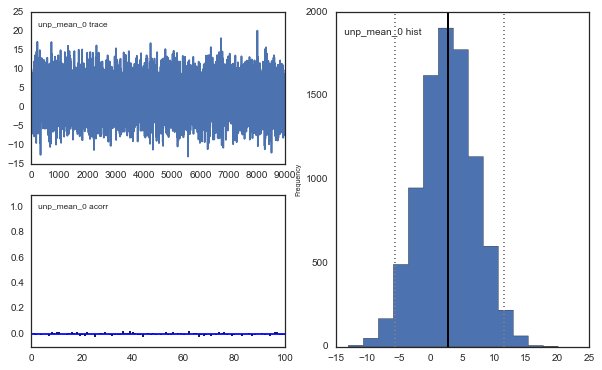

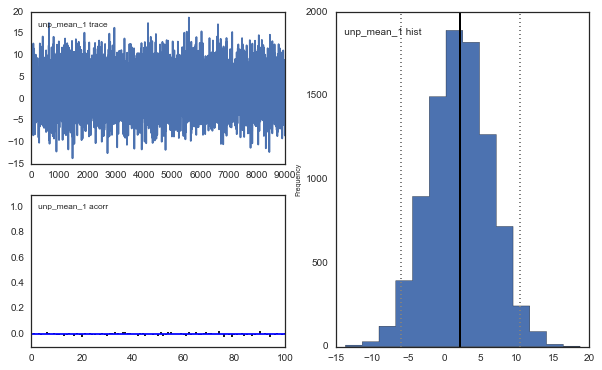

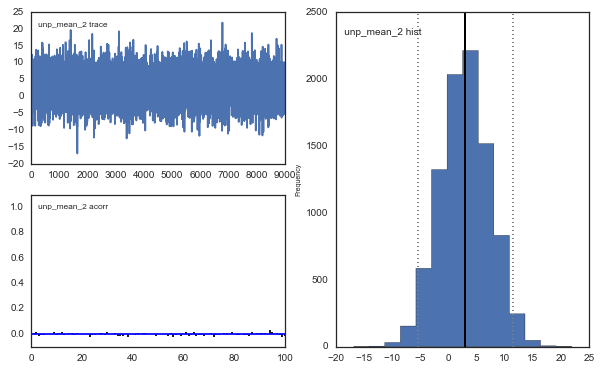

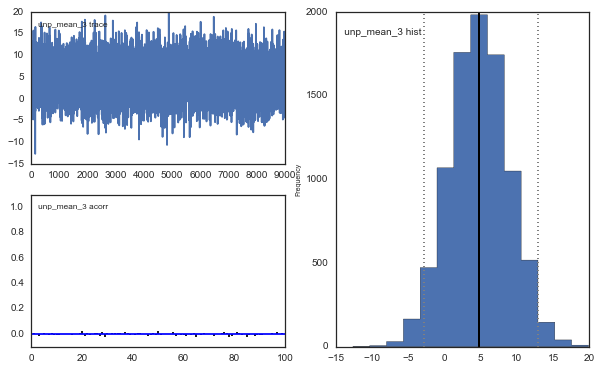

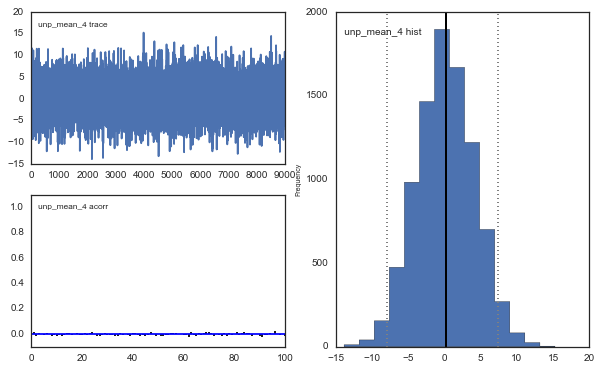

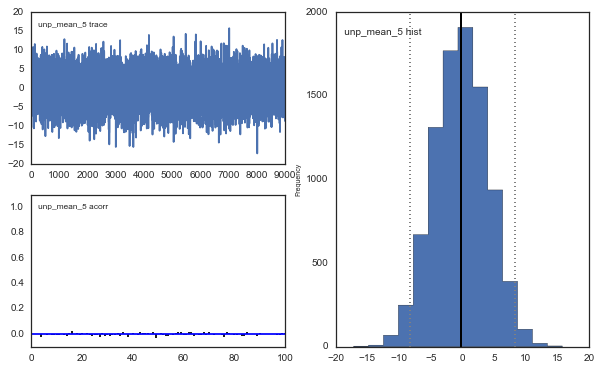

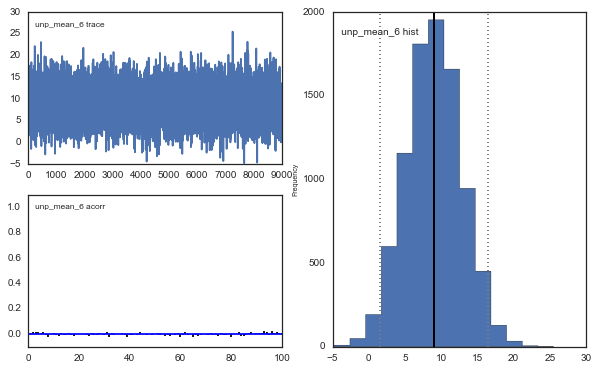

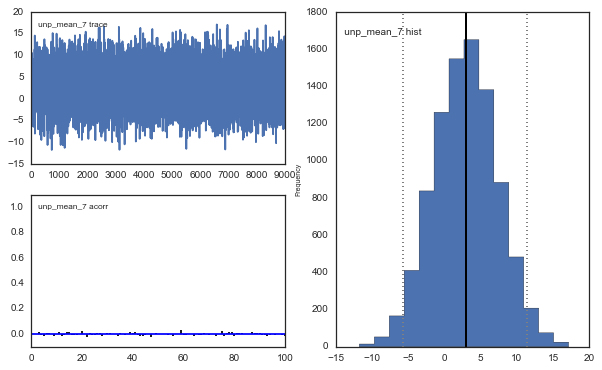

In [189]:
N = 8
mu = scipy.stats.norm.rvs(2., 2., size=N).tolist()

unp_means=pm.Container([pm.Normal("unp_mean_%i" % i, mu[i], mu_tau) for i in range(N)])

#generate likelihood
unp_likelihood = pm.Normal('likelihood', mu = unp_means, tau=tau, 
                        value = data_means, observed=True)

#create posterior model
unp_model = pm.Model([unp_means, unp_likelihood])
unp_mc = pm.MCMC(unp_model)
#generate sample from posterior
unp_mc.sample(iter=100000, burn=10000, thin=10)

#plot the trace
for i in range(N):
    pm.Matplot.plot(unp_means[i])

## 3. Partial pooling
Means are different for each company as in the unpooled case while they all share similarity. We can model this by assuming that each individual mean comes from a common distribution.

 [-----------------100%-----------------] 100000 of 100000 complete in 39.7 secPlotting pp_mean_0
Plotting pp_mean_1
Plotting pp_mean_2
Plotting pp_mean_3
Plotting pp_mean_4
Plotting pp_mean_5
Plotting pp_mean_6
Plotting pp_mean_7


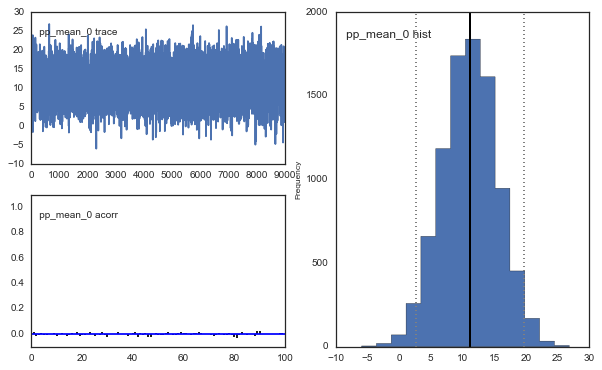

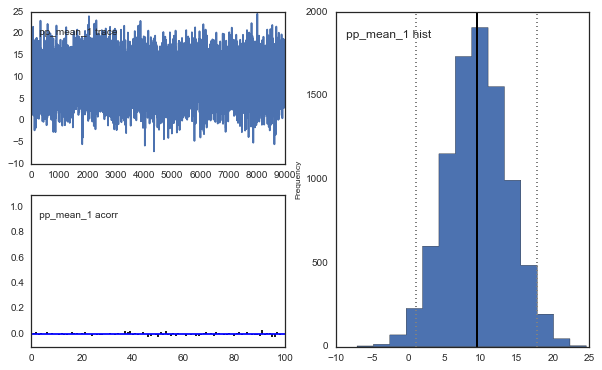

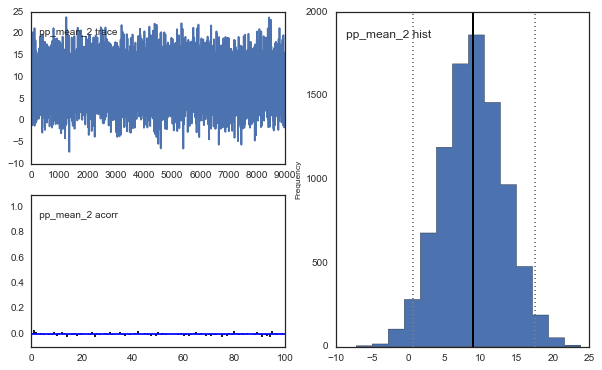

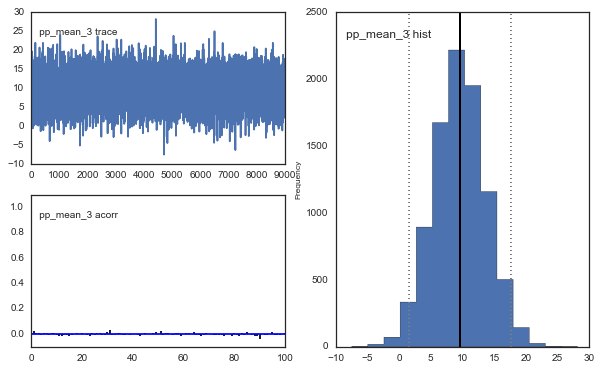

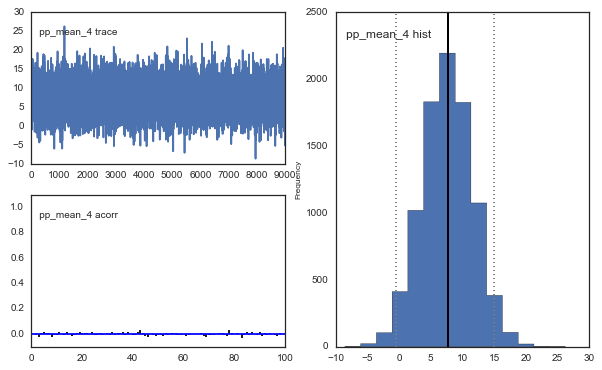

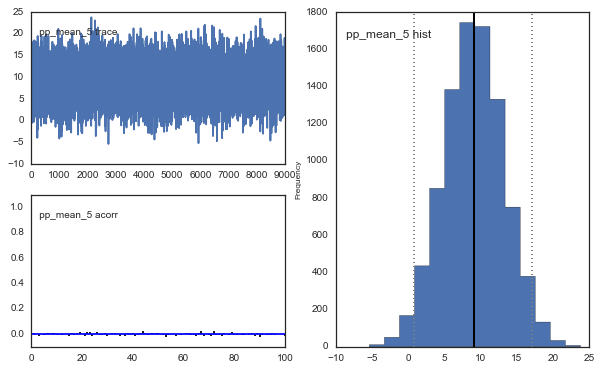

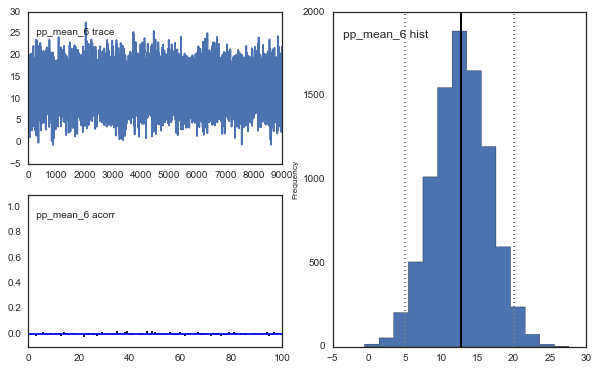

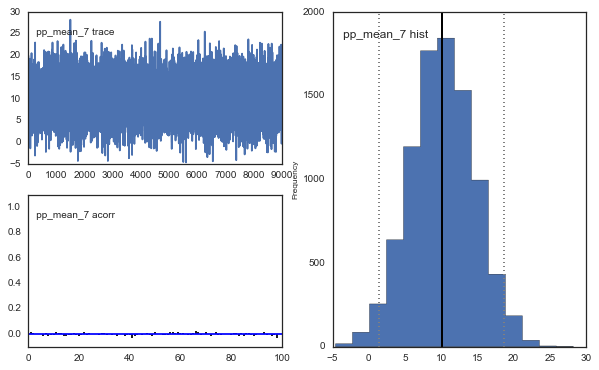

In [53]:
N = 8
mu = 2.

pp_means=pm.Container([pm.Normal("pp_mean_%i" % i, mu, mu_tau) for i in range(N)])

#generate likelihood
pp_likelihood = pm.Normal('likelihood', mu = pp_means, tau=tau, 
                        value = data_means, observed=True)

#create posterior model
pp_model = pm.Model([pp_means, pp_likelihood])
pp_mc = pm.MCMC(pp_model)
#generate sample from posterior
pp_mc.sample(iter=100000, burn=10000, thin=10)

#plot the trace
for i in range(N):
    pm.Matplot.plot(pp_means[i])

## Discussion:
As we can see from above:

At one extreme, the complete-pooling method gives identical estimates for all groups, which ignores the group effect. It is particularly inappropriate if the 8 companies are very different. However, it is reasonable if the 8 companies are very similar.

At the other extreme, unpooling means we estimate each mean independently. Here we are saying that companies share no similarities whatsoever. As we show above, this type of model can be very noisy.

Fortunately, there is a middle ground to both of these extremes. Specifically, we may assume that means are different for each company as in the unpooled case, they all share similarity. We can model this by assuming that each individual mean comes from a common distribution.

# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with the same length as $\mathbf{\hat{\theta_j}}$ and $\mathbf{b}$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.


$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

## Solution

**(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.**

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

$\mathcal{A_{\hat{k}}}$ refers to the starting positions of the motif within each sequence other than $\mathcal{S}_k$.

$Z$ is a normalization factor to make sure $\sum_{i=1}^{l}P(a_k=i) = 1$ holds.

$s_x$ is a vector index for the *x-th* position in the sequence. It has a length of q and it is 1 at entry that in b corresponds to the basein posistion x, 0 otherwise. For example, if the xth position of the sequence is M, then $s_x=(1,0,0,0,0)$

Vector $\mathbf{\hat{\theta_j}}$ contains respectively the probabilities of observing each entry in b at jth position of the motif. So we have a vector looks like this $(\theta_{M,j}, \theta_{0,j}, \theta_{2,j}. \theta_{A,j}, \theta_{7,j})$ where $\theta_{M,j}$ refers to the probability of observing M appears at jth position of the motif.

$\mathbf{\hat{\theta_0}}$ contains respectively the probabilities of observing each entry in b in the background. So we have a vector looks like this $(\theta_{M,0}, \theta_{0,0}, \theta_{2,0}. \theta_{A,0}, \theta_{7,0})$ where $\theta_{M,0}$ refers to the probability of observing M appears in the background.

## Algorithm

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.

In [24]:
data = []
for line in open('HW3/Sequences_new.dat', 'r'):
    data.append(line)

In [108]:
# initialize parameters
q=5 #length of motif
p=20 # number of sequences
l=200
b=['M','0','2','A','7'] # bases

In [175]:
# function to do one iteration to give a new alignment
def Gibbs(start, data, q, p, l, b):
    start_new = []
    for k in range(p):
        # data exclude kth sequence
        data_e = data[0:k] + data[k+1:p]
        # start position exclude k th sequence
        start_e = start[0:k]+start[k+1:p]
        # extract the motif of the left 19 sequences
        motif = [data_e[i][start_e[i]:(start_e[i]+5)] for i in range(p-1)]
        # extract the background of the left 19 sequences
        background = [data_e[i][0:start_e[i]]+data_e[i][start_e[i]+5:] for i in range(p-1)]
        # construct Theta matrix
        Theta = np.zeros((5, 5))
        theta_0 = np.zeros(5)
        for i in range(p-1):
            theta_0 += [background[i].count(b[h]) for h in range(len(b))] 
            for j in range(q):
                Theta[:,j] += [b[h]==motif[i][j] for h in range(len(b))]

        # Derive the conditional probability over all possible alignments for your current sequence
        prob_c = []
        for i in range(l-4):
            pr=1.
            for j in range(q):
                ind = b.index(data[k][i+j])
                pr = pr*(Theta[:,j]/theta_0)[ind]
            prob_c.append(pr)            
        # Normalize prob_c
        prob_c = [prob_c[i]/sum(prob_c) for i in range(len(prob_c))]
        # Draw a sample from the conditional prop.
        new_pos = np.random.choice(l-4, 1, p=prob_c)[0]
        # This sample will be your updated alignment for the current sequence.
        start_new.append(new_pos)
    return start_new

In [192]:
# try different random starting points and use a good one
start = [int(scipy.stats.uniform.rvs(0,194,size=p)[i]) for i in range(p)]
N = 100 #iteration number
alignment = np.zeros((p,N))

for i in range(N):
    start = Gibbs(start=start, data=data, q=q, p=p, l=l, b=b)
    for j in range(p):
        alignment[j,i] = start[j]

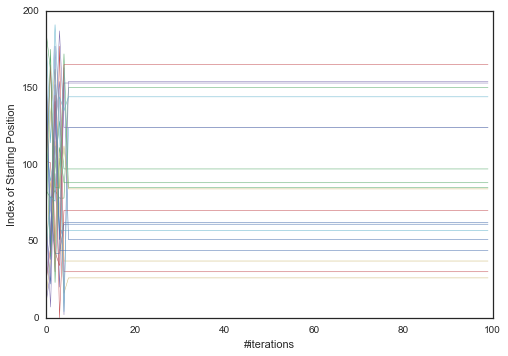

In [193]:
# check whether converge
for j in range(p):
    plt.plot(range(N), alignment[j], linewidth=0.5)
    plt.ylabel('Index of Starting Position')
    plt.xlabel('#iterations')

From the plot above, we can see that it converged.

In [196]:
# Get the converged position
start_pos = alignment[:,99]
print start_pos

[  62.  150.   30.  153.   26.   57.   51.   97.   70.  154.   37.  124.
   61.   85.  165.  124.   84.  144.   44.   88.]


In [198]:
# check what's the word
for i in range(p):
    pos = int(start_pos[i])
    print data[i][pos:pos+5]

AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207


### Motif
The motif is AM207.

# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [79]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])

# convert weight and item to float
w = w.astype(float)
v = v.astype(float)

## Simulated Annealing Solution
The algorithm solving the Knapsack Problem is as follows. 
We start with zero weight in your bag.

0. Record the current assortment of objects. We will call this item_index = {x1, x2,...,xn}, xi ∈ 0, 1

1. We pick L items at random with equal probability. L is decided by temperature (L = np.max((np.floor(np.sqrt(temperature)).astype(int),1))). 

2. Holding those items in hand, we assess whether to add them to our backpack.
    1. If adding those objects into our bag pushes us over the weight limit, we select an item at random
    with equal probability from those in our bag and those from our hand. We drop that item. We
    repeat this process until the objects in our bag are below the weight limit.  
    2. Otherwise, add those items to our bag.   
    3. Record the outcome as a trial assortment. We will call this item_index!
3. Compare the value of the trial assortment with the original.
    1. If new value is greater than original value, we accept the new trial assortment as the new assortment.
    2. If not, with some probability P=exp(new_value-old_value/temperature), we accept the new trial assortment as the new assortment. 

3. Adjust temperature

In [141]:
# given item_ind, calculate the total value of the items
def total_value(item_ind,w=w,v=v):
    return sum(v*item_ind)

def total_weight(item_ind,w=w):
    return sum(w*item_ind)

In [142]:
import copy
def changeindex(item_index, L, W=W):
    indices = range(len(item_index))
    items = copy.deepcopy(item_index)
    
    # We pick L items at random with equal probability.
    for i in range(L):
        ind= np.random.choice(indices)
        items[ind] = True
    
    #Holding those items in hand, we assess whether to add it to our backpack.
    while total_weight(items)>W:
        ind= np.random.choice(indices)
        items[ind] = False

    return items


In [169]:
# function for simulated annealing
# item_ind: index vector that i th entry indicates whether we bring the ith item
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol, otol: tolerance values for stopping 
# ftol: Not changing much anymore
# itol: maximum number of iterations
# otol: objective goal reached
# reannealing: schedule for reheating

#####
### THIS CODE IS RATHER MESSY AND DOES NOT INCLUDE KEEPING TRACK OF BEST POSITION SO FAR
### DO NOT JUST COPY PASTE THIS FOR THE HOMEWORK
#####

def simulated_annealing( item_ind, init_temp, thermostat, ftol, itol, otol, reannealing):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================

    m=10000     
    valsize=otol+1
    val=[]
    temperature = init_temp   


    N = len(item_ind)
    
    # number of accepted steps
    it = 0                    

    # Value HERE IS OUR ENERGY 
    prev_E = total_value(item_ind)  
    
    # number of iterations
    atp=0
    
    didPlot = False
    
    while it >=0:
        # adaptive step size 
        L = np.max((np.floor(np.sqrt(temperature)).astype(int),1))
#         print "L", L
        #L = 2
        propose_ind = changeindex(item_ind, L)

        new_E = total_value(propose_ind)
        deltaE  =  new_E -prev_E 
        

        if new_E > prev_E:
            item_ind  = propose_ind
            #val[it] =new_E
            val.append(new_E)
            prev_E = new_E  
            it = it+1
            didPlot = False

        elif np.random.rand() < np.exp(deltaE/temperature):
            item_ind  = propose_ind
            #val[it] =new_E
            val.append(new_E)
            prev_E = new_E  
            it = it+1
            didPlot = False

        atp =atp +1;  # NUMBER OF ITERATIONS
        
        # check if it is time to cool down
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            #temperature =  temperature/log(it);
            compl_temp=0;
            
            #if we get too cold, reheat
            if temperature < 0.01:
                temperature = 1
        
        if False: #some optional plotting
            if (it % 100 == 0) and not didPlot:       
                display.clear_output()
                plt.plot( val, '-r')
                display.display(plt.gcf())
                print len(val)
                print raw_input('Iteration: ' + np.str(atp))
                plt.close()
                didPlot = True
    
        if len(val)>m and np.std(val[-m:])/np.mean(val[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(val)> 0 and val[-1] <= otol:
            print 'otol'
            print val[-1]
            break

    s = item_ind
    return s, val

In [170]:
# simulated_annealing(item_index, init_temp, thermostat, ftol, itol, otol, reannealing):
item_index = [False]*N
items, value = simulated_annealing(item_index, 10.0, 0.9, 0.01, 200000, 0, 100)

ftol


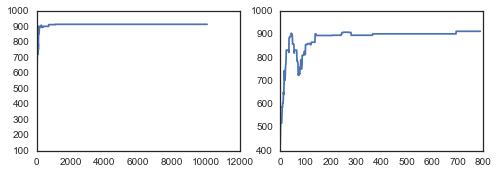

In [171]:
plt.figure(1)
plt.subplot(221)
plt.plot(value)

plt.subplot(222)
plt.plot(value[10:800])

In [172]:
print 'SA #inter:', len(value)
print 'SA weight:', total_weight(items)
print 'SA maximum value:', np.max(value)
print 'SA last value:', value[-1]
print 'SA #items of last assortment:', sum(items)
print 'SA taken items of last assortment:', [i for i in range(len(items)) if items[i]==True]

SA #inter: 10079
SA weight: 2995.0
SA maximum value: 916.0
SA last value: 916.0
SA #items of last assortment: 23
SA taken items of last assortment: [0, 3, 10, 17, 18, 19, 25, 38, 39, 41, 49, 50, 58, 68, 70, 77, 78, 79, 80, 85, 88, 92, 96]


From the plot above, we can see that it converged after 500 iterations. And the maximum value we get among all the iterations is the same as the value of last iteration. We will just use the assortment the last iteration give us as our final solution. According to the SA assortment, We should take 23 items which are [0, 1, 3, 10, 19, 25, 32, 38, 39, 41, 49, 50, 58, 68, 70, 77, 78, 79, 80, 85, 88, 92, 96]th item in the bag. The total weight of these items is 2995 and the total value of these items are 916.

## Greedy Algorithm
Sorts the items by the ratio vi/wi and puts them into the suitcase consecutively

In [147]:
def Greedy(item_index, v_w = v_w, W=W):
    items = copy.deepcopy(item_index)
    # an array store the index of the decreasing order of v_w
    item_order = (-v_w).argsort()
    for i in item_order:
        proposed = copy.deepcopy(items)
        proposed[i] = True
        if total_weight(proposed)<=W:
            items[i] = True        
    return items


In [148]:
v_w = v/w

#initialize index
item_index_g = [False]*N
item_index_g = Greedy(item_index)

In [149]:
print 'Greedy weight:', total_weight(item_index_g)
print 'Greedy value:', total_value(item_index_g)    
print 'Greedy #items:', sum(item_index_g)
print 'Greedy taken items:', [i for i in range(len(item_index_g)) if item_index_g[i]==True]

Greedy weight: 2806.0
Greedy value: 897.0
Greedy #items: 23
Greedy taken items: [0, 3, 10, 11, 18, 19, 32, 38, 39, 41, 49, 50, 58, 68, 70, 77, 78, 79, 80, 85, 88, 92, 96]


According to greedy algorithm, We should take 23 items which are [0, 3, 10, 11, 18, 19, 32, 38, 39, 41, 49, 50, 58, 68, 70, 77, 78, 79, 80, 85, 88, 92, 96]th item in the bag. The total weight of these items is 2806 and the total value of these items is 897, which is less than the value of the SA assortment.

# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

In [173]:
# Here is your data
reports = np.load("HW3/reports.npy")

### 1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels zi. Discuss the meaning and influence of the hyperparameter α on the true labels of the data.

$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

1. $\alpha$ and $\lambda$ in this case are parameters of priors called hyper-parameter. To simplify the problem, I will just use some fixed value.

2. $z_i$ is the true class of image i and the model for z is a multinomial with parameter $\rho$. We set a prior distribution for $\rho$, which is a Dirichlet distribution with parameter $\alpha$.

3. $\Theta$ is the confusion matrix. Each row of the $\Theta$ matrix follows Dirichlet distribution. 

    The first entry in the first row means that given the true class as 1, the number of images are classified as 1. The 2nd entry of the first row means given the true class as 1, the number of images are classifed as 2. The first entry in the 2nd row means that given the true class as 2, the number of images are classified as 1. The 2nd entry of the 2nd row means given the true class as 2, the number of images are classifed as 2. And the row number k indicates the true class of the image. As we mentioned above, to simplify the problem, we set the hyperparameter $\Lambda$ some fixed matrix value.

4. $r_{i,j}$ is the label the jth worker gives to the ith item. It follows multinomial distribution with parameter $\Theta_{z_i,:}$.

5. $\alpha$ is some hyperparameter that controls the prior of the distribution of the true classes(Multinimial distribution). Different $\alpha$ will influence the value of $\rho$ and thus influence the distribution of the true class.



### 2. Discuss your selection of the hyperparameter Λ and how that influences the confusion matrix Θ.

$\Lambda$ is the parameter of the distribution of $\Theta$ which is the distribution of the confusion matrix. The selection of $\Lambda$ should based on our previous knowledge about the difficulty of the correct classification of each class.

### 3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix Θ and the distribution of the true labels ρ. Note: Θ is shared by all three workers.

Our goal is to recover the underlying confusion matrix Θ and the distribution of the true labels ρ. Since each report is generated by individual judges independently of each other and each image is also independently sampled, the log-likelihood of the whole report will be sum of the likelihood of individual image,
$$\ln P(r|\Theta,z)=\sum_{n=1}^{150}\sum_{j=1}^{3}lnP(r_{n,j}|\Theta,z_n)$$

In [281]:
# initialize our parameters
N = 150 # number of data points
J = 3 # number of worksers
K = 2 # number of class

alpha = 1,1 # initialize alpha as a fixed value

# initialize Lambda matrix as fixed value 3,3
Lambda = np.ones((2,2)) 
Lambda[0],Lambda[1] = 3,3

### Reference: "http://alfan-farizki.blogspot.com/2015/07/pymc-tutorial-2-estimating-parameters.html"

In [282]:
# Model rho
rho = pm.CompletedDirichlet('rho', pm.Dirichlet('rho_1',theta = alpha))
# rho = pm.Dirichlet('rho',theta = alpha)

# Model zi, when n=1, multinomial is equivalent to categorical distribution
zi = pm.Container([pm.Categorical('z_{}'.format(i), p = rho) for i in range(N)])

# model Theta
Theta =pm.Container([pm.CompletedDirichlet('theta_c1',pm.Dirichlet('theta_d1', theta = Lambda[0])),
                     pm.CompletedDirichlet('theta_c2',pm.Dirichlet('theta_d2', theta = Lambda[1]))])

# model r, when n=1, multinomial is equivalent to categorical distribution
r = pm.Container([pm.Categorical("r_{}".format(i,j), 
                                 p = pm.Lambda("theta_{}".format(i),lambda zi = zi[i], Theta = Theta:Theta[zi]),
                                 value = reports[i][j],
                                 observed = True) 
                  for i in range(N) for j in range(J)])

In [283]:
model = pm.Model([rho,Theta,zi,r])
mcmc = pm.MCMC(model)
mcmc.sample(iter = 20000, burn = 1000, thin = 10)

 [-----------------100%-----------------] 20000 of 20000 complete in 1342.4 sec

Plotting rho_0_0
Plotting rho_0_1


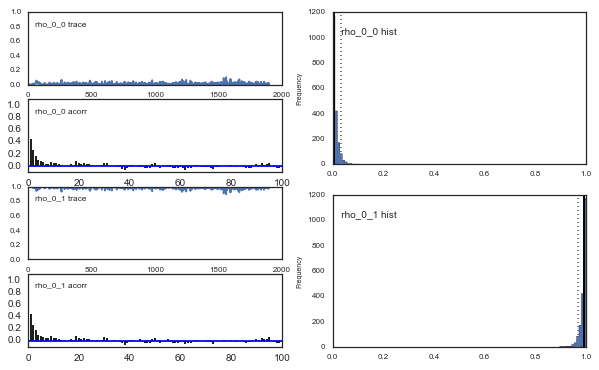

In [300]:
# Distribution of rho
pm.Matplot.plot(rho)

From the trace plot, we can see that it converged. The 2 plots on the right side are the distribution plot for $\rho_0$ and $\rho_1$.

Plotting theta_c1_0_0
Plotting theta_c1_0_1


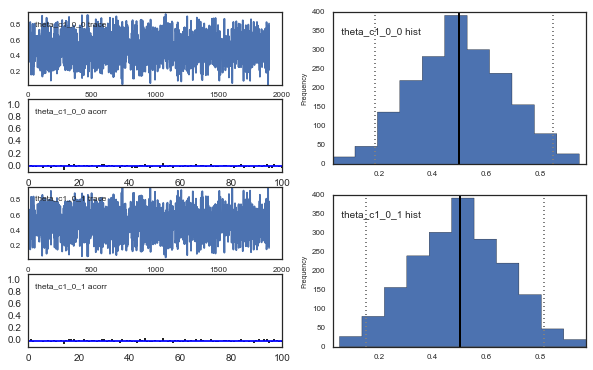

In [302]:
# Recover Confusion matrix
# Check the trace plot first to see whether it converged
pm.Matplot.plot(Theta[0])

Plotting theta_c2_0_0
Plotting theta_c2_0_1


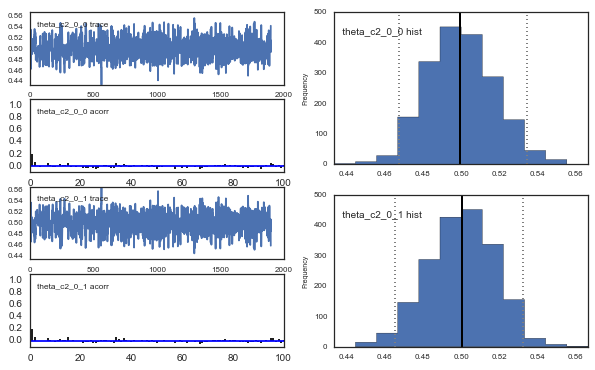

In [303]:
pm.Matplot.plot(Theta[1])

From the trace plots of $\Theta_0$ and $\Theta_1$, we can see both converged. So we can just take the last sample point of $\Theta_0$ and $\Theta_1$ to construct our confusion matrix.

In [306]:
# first row of recovered confusion matrix
mcmc.trace(Theta[0])[-1]

array([[ 0.82289883,  0.17710117]])

In [309]:
# second row of recovered confusion matrix
mcmc.trace(Theta[1])[-1]

array([[ 0.54127137,  0.45872863]])

In [312]:
confusion_matrix = np.vstack((mcmc.trace(Theta[0])[-1],mcmc.trace(Theta[1])[-1]))
print 'Confusion Matrix:'
print confusion_matrix

Confusion Matrix:
[[ 0.82289883  0.17710117]
 [ 0.54127137  0.45872863]]
